In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [26]:
DATA_DIR = Path("apnea-ecg-database-1.0.0")

FS = 100  # Hz

# Window length (60 seconds)
WINDOW_SEC = 60
WINDOW_SAMPLES = FS * WINDOW_SEC

print("Window samples:", WINDOW_SAMPLES)

Window samples: 6000


In [27]:
import wfdb
record_name = "a01"
record_path = DATA_DIR / record_name

signal, fields = wfdb.rdsamp(str(record_path))

print("Signal shape:", signal.shape)
print("Sampling frequency:", fields['fs'])

Signal shape: (2957000, 1)
Sampling frequency: 100


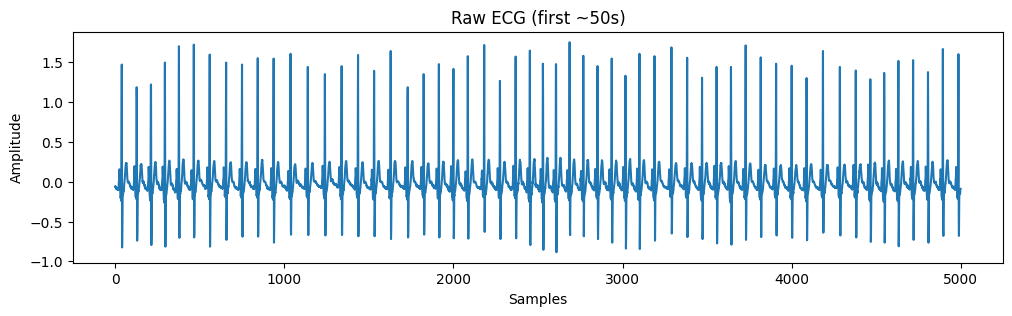

In [28]:
plt.figure(figsize=(12,3))
plt.plot(signal[:5000])
plt.title("Raw ECG (first ~50s)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

In [29]:
ann = wfdb.rdann(str(record_path), 'apn')

print("Annotation attributes:")
print([attr for attr in dir(ann) if not attr.startswith("_")])

Annotation attributes:
['ann_len', 'apply_range', 'aux_note', 'calc_cl_bytes', 'calc_core_bytes', 'calc_fs_bytes', 'chan', 'check_field', 'check_field_cohesion', 'check_fields', 'compact_fields', 'contained_labels', 'convert_label_attribute', 'create_label_map', 'custom_labels', 'description', 'extension', 'fs', 'get_available_label_stores', 'get_contained_labels', 'get_custom_label_attribute', 'get_label_fields', 'get_undefined_label_stores', 'label_store', 'num', 'record_name', 'rm_attributes', 'sample', 'set_label_elements', 'standardize_custom_labels', 'subtype', 'sym_to_aux', 'symbol', 'wr_ann_file', 'wrann']


In [30]:
print("Number of minutes:", len(ann.symbol))
print("First labels:", ann.symbol[:10])

Number of minutes: 489
First labels: ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']


In [32]:
ecg_signal = signal[:, 0]

print("ECG signal shape:", ecg_signal.shape)

ECG signal shape: (2957000,)


In [33]:
ecg_trimmed = ecg_signal[:required_samples]
print("Trimmed ECG shape:", ecg_trimmed.shape)

Trimmed ECG shape: (2934000,)


In [34]:
X = ecg_trimmed.reshape(
    n_minutes,
    WINDOW_SAMPLES,
    1
)

print("X shape:", X.shape)

X shape: (489, 6000, 1)


In [35]:
y = np.array([1 if l == 'A' else 0 for l in labels])

print("y shape:", y.shape)
print("First 20 labels:", y[:20])

y shape: (489,)
First 20 labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]


In [36]:
unique, counts = np.unique(y, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples")

Class 0: 19 samples
Class 1: 470 samples


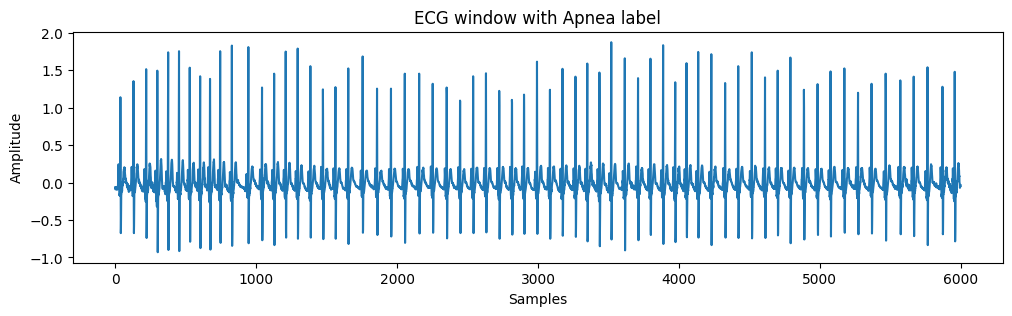

In [37]:
idx = np.where(y == 1)[0][0]  # πρώτο apnea window

plt.figure(figsize=(12, 3))
plt.plot(X[idx].squeeze())
plt.title("ECG window with Apnea label")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

In [38]:
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(19), np.int64(1): np.int64(470)}


In [39]:
import wfdb
from collections import Counter

# Training records according to PhysioNet
train_records = (
    [f"a{i:02d}" for i in range(1, 21)] +
    [f"b{i:02d}" for i in range(1, 6)] +
    [f"c{i:02d}" for i in range(1, 11)]
)

len(train_records), train_records[:5]

(35, ['a01', 'a02', 'a03', 'a04', 'a05'])

In [40]:
label_stats = {}

for rec in train_records:
    ann = wfdb.rdann(str(DATA_DIR / rec), 'apn')
    
    # ann.symbol is the correct attribute
    labels = ann.symbol
    
    counts = Counter(labels)
    label_stats[rec] = counts

In [41]:
for rec, counts in label_stats.items():
    n_normal = counts.get('N', 0)
    n_apnea = counts.get('A', 0)
    total = n_normal + n_apnea
    
    print(f"{rec}: N={n_normal:4d}, A={n_apnea:4d}, total={total}")

a01: N=  19, A= 470, total=489
a02: N= 108, A= 420, total=528
a03: N= 273, A= 246, total=519
a04: N=  39, A= 453, total=492
a05: N= 178, A= 276, total=454
a06: N= 304, A= 206, total=510
a07: N= 189, A= 322, total=511
a08: N= 312, A= 189, total=501
a09: N= 114, A= 381, total=495
a10: N= 417, A= 100, total=517
a11: N= 244, A= 222, total=466
a12: N=  43, A= 534, total=577
a13: N= 251, A= 244, total=495
a14: N= 126, A= 383, total=509
a15: N= 142, A= 368, total=510
a16: N= 162, A= 320, total=482
a17: N= 327, A= 158, total=485
a18: N=  51, A= 438, total=489
a19: N= 297, A= 205, total=502
a20: N= 195, A= 315, total=510
b01: N= 468, A=  19, total=487
b02: N= 424, A=  93, total=517
b03: N= 368, A=  73, total=441
b04: N= 419, A=  10, total=429
b05: N= 376, A=  57, total=433
c01: N= 484, A=   0, total=484
c02: N= 501, A=   1, total=502
c03: N= 454, A=   0, total=454
c04: N= 482, A=   0, total=482
c05: N= 463, A=   3, total=466
c06: N= 467, A=   1, total=468
c07: N= 425, A=   4, total=429
c08: N= 

In [44]:
SELECTED_RECORDS = [
    'a01','a02','a03','a04','a05','a06','a07','a08','a09','a10',
    'a11','a12','a13','a14','a15','a16','a17','a18','a19','a20',
    'b02'
]


In [53]:
def load_record_windows(record_name, data_dir):
    record_path = data_dir / record_name

    # Load ECG
    signal, fields = wfdb.rdsamp(str(record_path))
    ecg_signal = signal[:, 0].astype(np.float32)

    # Load apnea annotations
    ann = wfdb.rdann(str(record_path), 'apn')
    labels = np.array(ann.symbol)

    # Compute valid minutes
    max_full_minutes = ecg_signal.shape[0] // WINDOW_SAMPLES
    n_minutes = min(len(labels), max_full_minutes)

    if n_minutes == 0:
        return np.empty((0, WINDOW_SAMPLES, 1)), np.empty((0,), dtype=int), {}

    # Trim
    ecg_trimmed = ecg_signal[:n_minutes * WINDOW_SAMPLES]
    labels = labels[:n_minutes]

    # Reshape
    X = ecg_trimmed.reshape(n_minutes, WINDOW_SAMPLES, 1)
    y = np.array([1 if l == 'A' else 0 for l in labels])

    meta = {
        "record": record_name,
        "num_minutes": n_minutes
    }

    return X, y, meta


In [54]:
X_all = []
y_all = []
subjects = []

for rec in SELECTED_RECORDS:
    X_rec, y_rec, meta = load_record_windows(rec, DATA_DIR)
    print(f"{rec}: X_rec {X_rec.shape}, y_rec {y_rec.shape}")

    if len(y_rec) == 0:
        continue

    X_all.append(X_rec)
    y_all.append(y_rec)
    subjects.extend([rec] * len(y_rec))


a01: X_rec (489, 6000, 1), y_rec (489,)
a02: X_rec (528, 6000, 1), y_rec (528,)
a03: X_rec (519, 6000, 1), y_rec (519,)
a04: X_rec (492, 6000, 1), y_rec (492,)
a05: X_rec (453, 6000, 1), y_rec (453,)
a06: X_rec (509, 6000, 1), y_rec (509,)
a07: X_rec (510, 6000, 1), y_rec (510,)
a08: X_rec (500, 6000, 1), y_rec (500,)
a09: X_rec (495, 6000, 1), y_rec (495,)
a10: X_rec (516, 6000, 1), y_rec (516,)
a11: X_rec (466, 6000, 1), y_rec (466,)
a12: X_rec (577, 6000, 1), y_rec (577,)
a13: X_rec (494, 6000, 1), y_rec (494,)
a14: X_rec (509, 6000, 1), y_rec (509,)
a15: X_rec (509, 6000, 1), y_rec (509,)
a16: X_rec (481, 6000, 1), y_rec (481,)
a17: X_rec (484, 6000, 1), y_rec (484,)
a18: X_rec (489, 6000, 1), y_rec (489,)
a19: X_rec (502, 6000, 1), y_rec (502,)
a20: X_rec (510, 6000, 1), y_rec (510,)
b02: X_rec (517, 6000, 1), y_rec (517,)


In [55]:
X = np.concatenate(X_all, axis=0)
y = np.concatenate(y_all, axis=0)
subjects = np.array(subjects)

print("FINAL DATASET")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique subjects:", len(np.unique(subjects)))
print("Label distribution:", dict(zip(*np.unique(y, return_counts=True))))


FINAL DATASET
X shape: (10549, 6000, 1)
y shape: (10549,)
Unique subjects: 21
Label distribution: {np.int64(0): np.int64(4209), np.int64(1): np.int64(6340)}


In [56]:
import numpy as np

SEED = 42
rng = np.random.default_rng(SEED)

unique_subjects = np.unique(subjects)
print("All subjects:", unique_subjects)
print("Number of subjects:", len(unique_subjects))


All subjects: ['a01' 'a02' 'a03' 'a04' 'a05' 'a06' 'a07' 'a08' 'a09' 'a10' 'a11' 'a12'
 'a13' 'a14' 'a15' 'a16' 'a17' 'a18' 'a19' 'a20' 'b02']
Number of subjects: 21


In [57]:
shuffled_subjects = unique_subjects.copy()
rng.shuffle(shuffled_subjects)

train_subjects = shuffled_subjects[:15]
val_subjects   = shuffled_subjects[15:18]
test_subjects  = shuffled_subjects[18:]

print("Train subjects:", train_subjects)
print("Val subjects:", val_subjects)
print("Test subjects:", test_subjects)


Train subjects: ['a17' 'a11' 'a16' 'b02' 'a13' 'a15' 'a08' 'a07' 'a10' 'a04' 'a01' 'a18'
 'a06' 'a12' 'a20']
Val subjects: ['a03' 'a05' 'a19']
Test subjects: ['a02' 'a14' 'a09']


In [58]:
def subject_mask(subject_array, subject_list):
    subject_set = set(subject_list)
    return np.array([s in subject_set for s in subject_array])

train_mask = subject_mask(subjects, train_subjects)
val_mask   = subject_mask(subjects, val_subjects)
test_mask  = subject_mask(subjects, test_subjects)

X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask],   y[val_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (7543, 6000, 1) (7543,)
Val:   (1474, 6000, 1) (1474,)
Test:  (1532, 6000, 1) (1532,)


In [60]:
from collections import Counter

def print_split_stats(name, y_split):
    c = Counter(y_split)
    total = len(y_split)
    print(f"{name}: total={total}, "
          f"Normal={c.get(0,0)}, Apnea={c.get(1,0)}, "
          f"Apnea%={100*c.get(1,0)/total:.1f}%")

print_split_stats("Train", y_train)
print_split_stats("Val",   y_val)
print_split_stats("Test",  y_test)


Train: total=7543, Normal=3114, Apnea=4429, Apnea%=58.7%
Val: total=1474, Normal=747, Apnea=727, Apnea%=49.3%
Test: total=1532, Normal=348, Apnea=1184, Apnea%=77.3%


In [61]:
import numpy as np

train_mean = X_train.mean()
train_std  = X_train.std() + 1e-8

print("Train mean:", train_mean)
print("Train std:", train_std)

def normalize(X, mean, std):
    return (X - mean) / std

X_train_n = normalize(X_train, train_mean, train_std)
X_val_n   = normalize(X_val,   train_mean, train_std)
X_test_n  = normalize(X_test,  train_mean, train_std)

print("Normalized shapes:", X_train_n.shape, X_val_n.shape, X_test_n.shape)


Train mean: -0.007171892
Train std: 0.571598
Normalized shapes: (7543, 6000, 1) (1474, 6000, 1) (1532, 6000, 1)


In [62]:
from collections import Counter

def compute_class_weights(y):
    c = Counter(y)
    total = len(y)
    w0 = total / (2.0 * c.get(0, 1))
    w1 = total / (2.0 * c.get(1, 1))
    return {0: w0, 1: w1}, c

class_weights, train_counts = compute_class_weights(y_train)
print("Train counts:", train_counts)
print("Class weights:", class_weights)


Train counts: Counter({np.int64(1): 4429, np.int64(0): 3114})
Class weights: {0: 1.2111432241490045, 1: 0.8515466245202077}


In [63]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

WINDOW_SAMPLES = X_train.shape[1]

def make_baseline_cnn(input_shape=(WINDOW_SAMPLES, 1)):
    inp = keras.Input(shape=input_shape)

    x = layers.Conv1D(16, kernel_size=7, padding="same")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(32, kernel_size=5, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(64, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)

    out = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.BinaryAccuracy(name="acc"),
            keras.metrics.AUC(name="auc"),
        ]
    )
    return model

model = make_baseline_cnn()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 6000, 16)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6000, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 6000, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3000, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3000, 32)       │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3000, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1500, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1500, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,441 (36.88 KB)

 Trainable params: 9,217 (36.00 KB)

 Non-trainable params: 224 (896.00 B)

In [64]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_auc", mode="max", patience=8, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc", mode="max", factor=0.5, patience=3, min_lr=1e-6
    ),
]

history = model.fit(
    X_train_n, y_train,
    validation_data=(X_val_n, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - acc: 0.6707 - auc: 0.7207 - loss: 0.6215 - val_acc: 0.5488 - val_auc: 0.6111 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 2/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - acc: 0.6991 - auc: 0.7597 - loss: 0.5884 - val_acc: 0.6031 - val_auc: 0.6189 - val_loss: 0.7811 - learning_rate: 0.0010
Epoch 3/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - acc: 0.7140 - auc: 0.7806 - loss: 0.5679 - val_acc: 0.5068 - val_auc: 0.6184 - val_loss: 1.0533 - learning_rate: 0.0010
Epoch 4/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - acc: 0.7244 - auc: 0.7914 - loss: 0.5560 - val_acc: 0.5889 - val_auc: 0.6251 - val_loss: 0.7679 - learning_rate: 0.0010
Epoch 5/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - acc: 0.7282 - auc: 0.7988 - loss: 0.5460 - val_acc: 0.5651 - val_auc: 0.6327 - val_loss: 0.7117 - learning_rate: 0.0010
Epoch 6/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - acc: 0.7341 - auc: 0.8085 - loss: 0.5332 - val_acc: 0.5665 - val

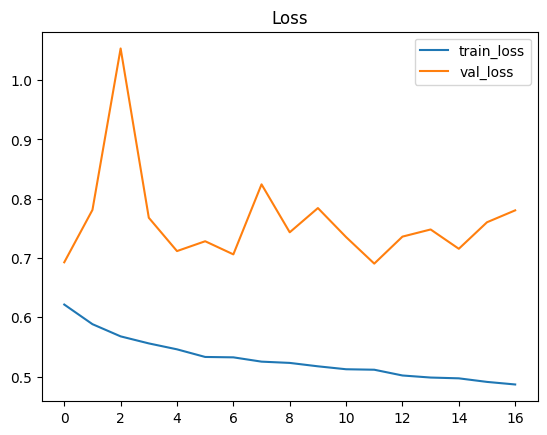

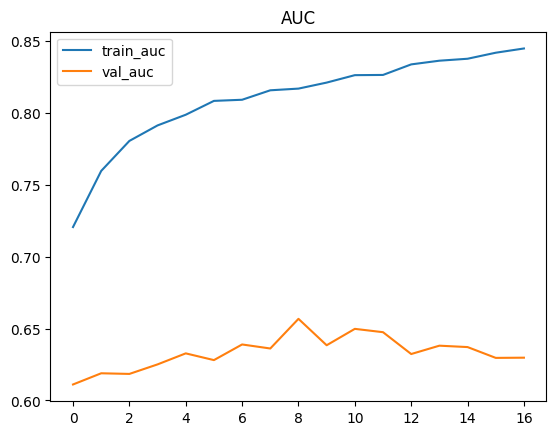

In [65]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.figure()
plt.plot(history.history["auc"], label="train_auc")
plt.plot(history.history["val_auc"], label="val_auc")
plt.legend()
plt.title("AUC")
plt.show()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

VAL @thr=0.50: acc=0.568, f1=0.386, auc=0.657
Confusion matrix:
 [[637 110]
 [527 200]]
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

TEST @thr=0.50: acc=0.584, f1=0.705, auc=0.570
Confusion matrix:
 [[133 215]
 [423 761]]


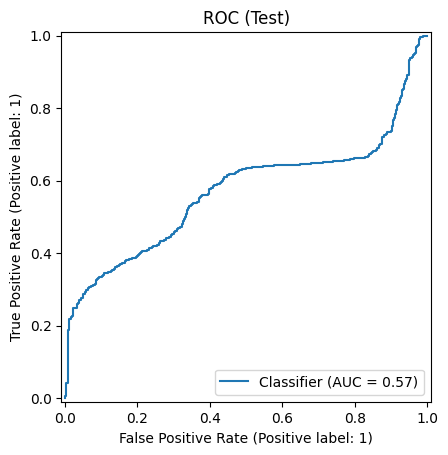

In [66]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay

def eval_split(model, Xs, ys, name="split", threshold=0.5):
    probs = model.predict(Xs, batch_size=64).ravel()
    preds = (probs >= threshold).astype(int)

    acc = accuracy_score(ys, preds)
    f1  = f1_score(ys, preds, zero_division=0)
    auc = roc_auc_score(ys, probs) if len(np.unique(ys)) > 1 else np.nan
    cm  = confusion_matrix(ys, preds)

    print(f"\n{name.upper()} @thr={threshold:.2f}: acc={acc:.3f}, f1={f1:.3f}, auc={auc:.3f}")
    print("Confusion matrix:\n", cm)
    return probs, preds

p_val, _  = eval_split(model, X_val_n,  y_val,  "val", threshold=0.5)
p_test, _ = eval_split(model, X_test_n, y_test, "test", threshold=0.5)

RocCurveDisplay.from_predictions(y_test, p_test)
plt.title("ROC (Test)")
plt.show()


In [67]:
thresholds = np.linspace(0.05, 0.95, 19)
best_thr, best_f1 = 0.5, -1

for thr in thresholds:
    preds = (p_val >= thr).astype(int)
    f1 = f1_score(y_val, preds, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

print("Best threshold (val):", best_thr)
print("Best F1 (val):", best_f1)

# Re-evaluate with tuned threshold
_ = eval_split(model, X_val_n,  y_val,  "val",  threshold=best_thr)
_ = eval_split(model, X_test_n, y_test, "test", threshold=best_thr)


Best threshold (val): 0.1
Best F1 (val): 0.6855378281008749
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

VAL @thr=0.10: acc=0.585, f1=0.686, auc=0.657
Confusion matrix:
 [[197 550]
 [ 61 666]]
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

TEST @thr=0.10: acc=0.769, f1=0.869, auc=0.570
Confusion matrix:
 [[   8  340]
 [  14 1170]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


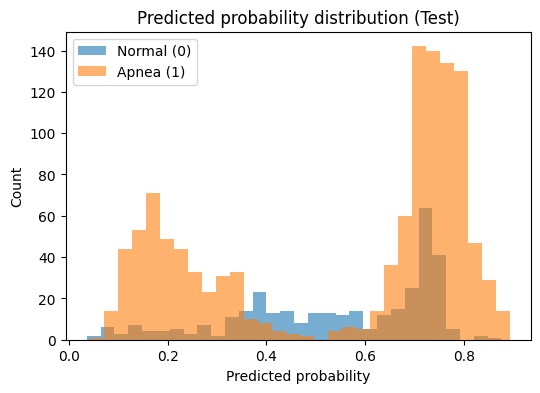

In [68]:
import matplotlib.pyplot as plt

probs_test = model.predict(X_test_n, batch_size=64).ravel()

plt.figure(figsize=(6,4))
plt.hist(probs_test[y_test==0], bins=30, alpha=0.6, label="Normal (0)")
plt.hist(probs_test[y_test==1], bins=30, alpha=0.6, label="Apnea (1)")
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.legend()
plt.title("Predicted probability distribution (Test)")
plt.show()


In [69]:
import numpy as np
from sklearn.metrics import roc_auc_score

rand_probs = np.random.rand(len(y_test))
rand_auc = roc_auc_score(y_test, rand_probs)

print("Model test AUC:", roc_auc_score(y_test, probs_test))
print("Random baseline AUC:", rand_auc)


Model test AUC: 0.570186296210003
Random baseline AUC: 0.4947746776949363


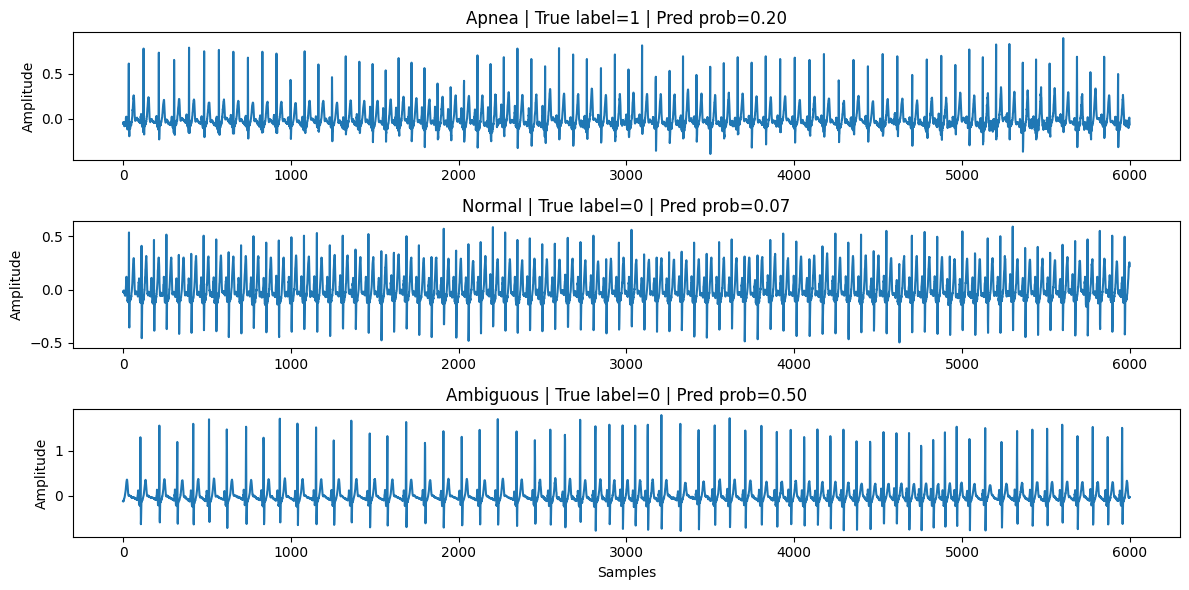

In [70]:
idx_apnea  = np.where(y_test == 1)[0][0]
idx_normal = np.where(y_test == 0)[0][0]

idx_amb = np.argmin(np.abs(probs_test - 0.5))

indices = [
    ("Apnea", idx_apnea),
    ("Normal", idx_normal),
    ("Ambiguous", idx_amb),
]

plt.figure(figsize=(12,6))

for i, (name, idx) in enumerate(indices, 1):
    plt.subplot(3,1,i)
    plt.plot(X_test[idx].squeeze())
    plt.title(
        f"{name} | True label={y_test[idx]} | "
        f"Pred prob={probs_test[idx]:.2f}"
    )
    plt.ylabel("Amplitude")

plt.xlabel("Samples")
plt.tight_layout()
plt.show()


In [71]:
DS = 10

def downsample(X, factor):
    return X[:, ::factor, :]

X_train_lstm = downsample(X_train_n, DS)
X_val_lstm   = downsample(X_val_n,   DS)
X_test_lstm  = downsample(X_test_n,  DS)

print("LSTM shapes:")
print("Train:", X_train_lstm.shape)
print("Val:  ", X_val_lstm.shape)
print("Test: ", X_test_lstm.shape)


LSTM shapes:
Train: (7543, 600, 1)
Val:   (1474, 600, 1)
Test:  (1532, 600, 1)


In [72]:
from tensorflow import keras
from tensorflow.keras import layers

def make_lstm_model(input_shape=(600, 1)):
    inp = keras.Input(shape=input_shape)

    x = layers.LSTM(64, return_sequences=False)(inp)
    x = layers.Dropout(0.3)(x)

    out = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.BinaryAccuracy(name="acc"),
            keras.metrics.AUC(name="auc"),
        ]
    )
    return model

lstm_model = make_lstm_model(input_shape=X_train_lstm.shape[1:])
lstm_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 600, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_auc", mode="max", patience=8, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc", mode="max", factor=0.5, patience=3, min_lr=1e-6
    ),
]

history_lstm = lstm_model.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - acc: 0.5569 - auc: 0.5572 - loss: 0.6892 - val_acc: 0.5210 - val_auc: 0.5518 - val_loss: 0.7446 - learning_rate: 0.0010
Epoch 2/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - acc: 0.5576 - auc: 0.5748 - loss: 0.6867 - val_acc: 0.5224 - val_auc: 0.5187 - val_loss: 0.6979 - learning_rate: 0.0010
Epoch 3/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - acc: 0.5543 - auc: 0.5619 - loss: 0.6897 - val_acc: 0.5122 - val_auc: 0.4940 - val_loss: 0.6999 - learning_rate: 0.0010
Epoch 4/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - acc: 0.5556 - auc: 0.5335 - loss: 0.6918 - val_acc: 0.5095 - val_auc: 0.5175 - val_loss: 0.6973 - learning_rate: 0.0010
Epoch 5/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - acc: 0.5906 - auc: 0.5964 - loss: 0.6837 - val_acc: 0.5047 - val_auc: 0.5152 - val_loss: 0.6985 - learning_rate: 5.0000e-04
Epoch 6/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - acc: 0.5917 - auc: 0.6040 - loss: 0.6809 - val_acc: 0.4959 -

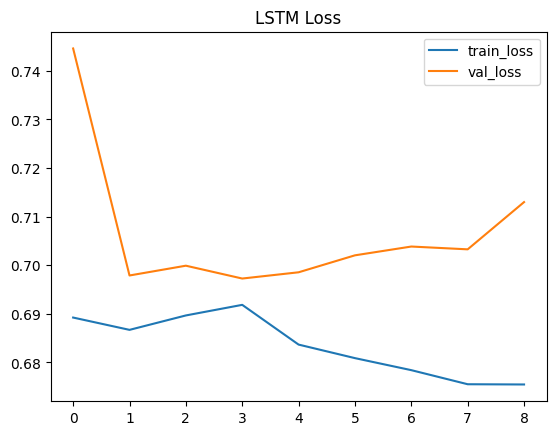

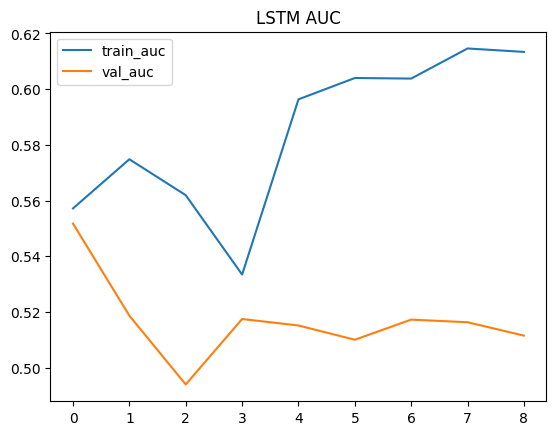

In [74]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_lstm.history["loss"], label="train_loss")
plt.plot(history_lstm.history["val_loss"], label="val_loss")
plt.legend()
plt.title("LSTM Loss")
plt.show()

plt.figure()
plt.plot(history_lstm.history["auc"], label="train_auc")
plt.plot(history_lstm.history["val_auc"], label="val_auc")
plt.legend()
plt.title("LSTM AUC")
plt.show()


In [75]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

def eval_split(model, Xs, ys, name="split", threshold=0.5):
    probs = model.predict(Xs, batch_size=64).ravel()
    preds = (probs >= threshold).astype(int)

    acc = accuracy_score(ys, preds)
    f1  = f1_score(ys, preds, zero_division=0)
    auc = roc_auc_score(ys, probs) if len(set(ys)) > 1 else float("nan")
    cm  = confusion_matrix(ys, preds)

    print(f"\n{name.upper()} @thr={threshold:.2f}: acc={acc:.3f}, f1={f1:.3f}, auc={auc:.3f}")
    print("Confusion matrix:\n", cm)

    return probs

p_val_lstm  = eval_split(lstm_model, X_val_lstm,  y_val,  "val")
p_test_lstm = eval_split(lstm_model, X_test_lstm, y_test, "test")


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step

VAL @thr=0.50: acc=0.521, f1=0.340, auc=0.552
Confusion matrix:
 [[586 161]
 [545 182]]
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step

TEST @thr=0.50: acc=0.736, f1=0.845, auc=0.518
Confusion matrix:
 [[  23  325]
 [  79 1105]]


In [76]:
SUBSEQ_LEN = 600   # 6 seconds
N_SUBSEQ = 10

def reshape_for_cnn_lstm(X):
    return X.reshape(X.shape[0], N_SUBSEQ, SUBSEQ_LEN, 1)

Xtr = reshape_for_cnn_lstm(X_train)
Xva = reshape_for_cnn_lstm(X_val)
Xte = reshape_for_cnn_lstm(X_test)

print(Xtr.shape)  # (N, 10, 600, 1)


(7543, 10, 600, 1)


In [77]:
from tensorflow.keras import layers, models

def build_cnn_encoder():
    inp = layers.Input(shape=(600, 1))
    
    x = layers.Conv1D(16, 7, padding="same")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(32, 5, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling1D()(x)

    return models.Model(inp, x, name="cnn_encoder")


In [78]:
cnn_encoder = build_cnn_encoder()

inp = layers.Input(shape=(N_SUBSEQ, SUBSEQ_LEN, 1))

x = layers.TimeDistributed(cnn_encoder)(inp)
x = layers.LSTM(64, return_sequences=False)(x)
x = layers.Dropout(0.5)(x)

out = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inp, out)


In [79]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc")
    ]
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 10, 600, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 64)         │         9,376 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,241 (165.00 KB)

 Non-trainable params: 224 (896.00 B)

In [80]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc",
        mode="max",
        factor=0.5,
        patience=3
    )
]

history = model.fit(
    Xtr, y_train,
    validation_data=(Xva, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.6800 - auc: 0.7418 - loss: 0.5991 - val_accuracy: 0.5916 - val_auc: 0.6268 - val_loss: 0.6925 - learning_rate: 0.0010
Epoch 2/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.7196 - auc: 0.7950 - loss: 0.5457 - val_accuracy: 0.5902 - val_auc: 0.6130 - val_loss: 0.7204 - learning_rate: 0.0010
Epoch 3/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.7318 - auc: 0.8134 - loss: 0.5223 - val_accuracy: 0.5570 - val_auc: 0.6143 - val_loss: 0.7064 - learning_rate: 0.0010
Epoch 4/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7467 - auc: 0.8265 - loss: 0.5076 - val_accuracy: 0.5631 - val_auc: 0.6095 - val_loss: 0.7071 - learning_rate: 0.0010
Epoch 5/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.7551 - auc: 0.8440 - loss: 0.4840 - val_accuracy: 0.5794 - val_auc: 0.6374 - val_loss: 0.7300 - learning_rate: 5.0000e-04
Epoch 6/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.765

In [84]:
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)


X_val shape: (1474, 6000, 1)
X_test shape: (1532, 6000, 1)


In [86]:
def to_cnn_lstm(X):
    # X: (N, 6000, 1)
    N = X.shape[0]
    return X.reshape(N, 10, 600, 1)

X_val_cnnlstm  = to_cnn_lstm(X_val)
X_test_cnnlstm = to_cnn_lstm(X_test)


In [87]:
print(X_val_cnnlstm.shape)
# (1474, 10, 600, 1)

(1474, 10, 600, 1)


In [88]:
y_val_prob  = model.predict(X_val_cnnlstm).ravel()
y_test_prob = model.predict(X_test_cnnlstm).ravel()


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [89]:
print(X_val.shape)


(1474, 6000, 1)


In [90]:
from sklearn.metrics import roc_auc_score

val_auc  = roc_auc_score(y_val, y_val_prob)
test_auc = roc_auc_score(y_test, y_test_prob)

print(f"VAL AUC:  {val_auc:.3f}")
print(f"TEST AUC: {test_auc:.3f}")


VAL AUC:  0.873
TEST AUC: 0.602


In [91]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

thr = 0.5
y_test_pred = (y_test_prob >= thr).astype(int)

acc = accuracy_score(y_test, y_test_pred)
f1  = f1_score(y_test, y_test_pred)
cm  = confusion_matrix(y_test, y_test_pred)

print(f"TEST @thr=0.50 | acc={acc:.3f}, f1={f1:.3f}")
print("Confusion matrix:\n", cm)
print(classification_report(y_test, y_test_pred, digits=3))


TEST @thr=0.50 | acc=0.529, f1=0.626
Confusion matrix:
 [[205 143]
 [579 605]]
              precision    recall  f1-score   support

           0      0.261     0.589     0.362       348
           1      0.809     0.511     0.626      1184

    accuracy                          0.529      1532
   macro avg      0.535     0.550     0.494      1532
weighted avg      0.684     0.529     0.566      1532



In [92]:
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.linspace(0.05, 0.95, 91)
f1_scores = []

for t in thresholds:
    y_val_pred = (y_val_prob >= t).astype(int)
    f1_scores.append(f1_score(y_val, y_val_pred))

best_thr = thresholds[np.argmax(f1_scores)]
best_f1  = np.max(f1_scores)

print(f"Best threshold (val): {best_thr:.2f}")
print(f"Best F1 (val): {best_f1:.3f}")


Best threshold (val): 0.15
Best F1 (val): 0.812


In [93]:
y_test_pred_opt = (y_test_prob >= best_thr).astype(int)

acc_opt = accuracy_score(y_test, y_test_pred_opt)
f1_opt  = f1_score(y_test, y_test_pred_opt)
cm_opt  = confusion_matrix(y_test, y_test_pred_opt)

print(f"TEST @thr={best_thr:.2f} | acc={acc_opt:.3f}, f1={f1_opt:.3f}")
print("Confusion matrix:\n", cm_opt)


TEST @thr=0.15 | acc=0.759, f1=0.860
Confusion matrix:
 [[  26  322]
 [  47 1137]]


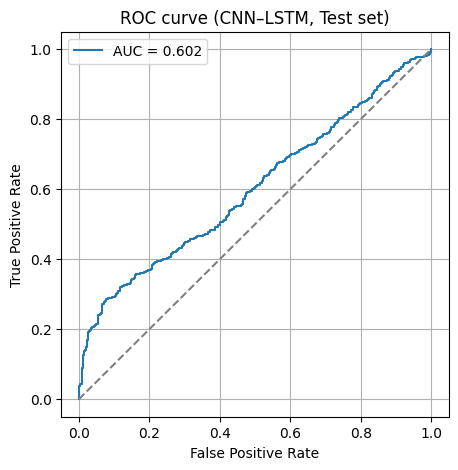

In [94]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_test_prob)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (CNN–LSTM, Test set)")
plt.legend()
plt.grid(True)
plt.show()
